In [1]:
import os
import sys

import h5py
import numpy as np
import orbax.checkpoint as ocp
import seaborn as sns
from flax import nnx

sys.path.insert(0, os.path.abspath("../.."))

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.collections import LineCollection

from transformers.data_utils.bb_data_loading import load_list
from transformers.models.pref_transformer import load_PT

In [2]:
p_list = load_list("../participant_list.txt")

In [3]:
p_id = np.random.choice(p_list)
with h5py.File(f"../participant_trajectories/state_data_1/{p_id}.hdf5") as f:
    r_idx = np.random.choice(f["states"].shape[0])
    sts = f["states"][r_idx, ...].reshape(1, 100, 16)
    acts = f["actions"][r_idx, ...].reshape(1, 100, 3)
    ts = f["timesteps"][r_idx, ...].reshape(1, 100)
    am = f["attn_mask"][r_idx, ...].reshape(1, 100)

In [4]:
n_rewards = []
n_all_weights = []
n_max_reward = -np.inf
n_min_reward = np.inf

n_max_weight = -np.inf
n_min_weight = np.inf

all_rewards = []

pr = []

reward_function = os.path.expanduser(
    "~/busy-beeway/transformers/t0012/pt_rewards/best_model.ckpt"
)
checkpointer = ocp.Checkpointer(ocp.CompositeCheckpointHandler())
r_model = load_PT(reward_function, checkpointer, on_cpu=True)
r_model = nnx.jit(r_model, static_argnums=4)
checkpointer.close()
for i in range(int(np.max(sts[:, :, 15]))):
    sts[:, :, 15] = np.where(am != 0, i, sts[:, :, 15])
    n_pred, n_weights = r_model(sts, acts, ts, am, training=False)

    n_r_pred = n_pred["value"].reshape(
        100,
    )

    am_sum = int(np.sum(am))
    n_r_pred = n_r_pred[:am_sum]
    n_max_r_pred = np.max(n_r_pred)
    if n_max_r_pred > n_max_reward:
        n_max_reward = n_max_r_pred

    n_min_r_pred = np.min(n_r_pred)
    if n_min_r_pred < n_min_reward:
        n_min_reward = n_min_r_pred

    n_ts = np.arange(am_sum)
    n_rewards.append(np.column_stack([n_ts, n_r_pred]))
    all_rewards.append(n_r_pred)
    n_weights = n_weights[-1].reshape(1, 100, 100)
    n_weights = np.mean(n_weights, axis=1).reshape(
        100,
    )
    n_weights = n_weights[:am_sum]
    n_all_weights.append(np.column_stack([n_ts, n_weights]))
    n_max_w = np.max(n_weights)
    if n_max_w > n_max_weight:
        n_max_weight = n_max_w

In [5]:
start_control_idxs = []
end_control_idxs = []
for i in range(100):
    if acts[0, i, 2] == 1:
        if i == 0:
            start_control_idxs.append(i)
        else:
            if acts[0, i - 1, 2] == 0:
                start_control_idxs.append(i)
    else:
        if acts[0, i - 1, 2] == 1:
            end_control_idxs.append(i)

In [6]:
all_rewards = np.stack(all_rewards)
norm_rewards = (all_rewards - np.min(all_rewards, axis=0)) / (
    np.max(all_rewards, axis=0) - np.min(all_rewards, axis=0)
)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

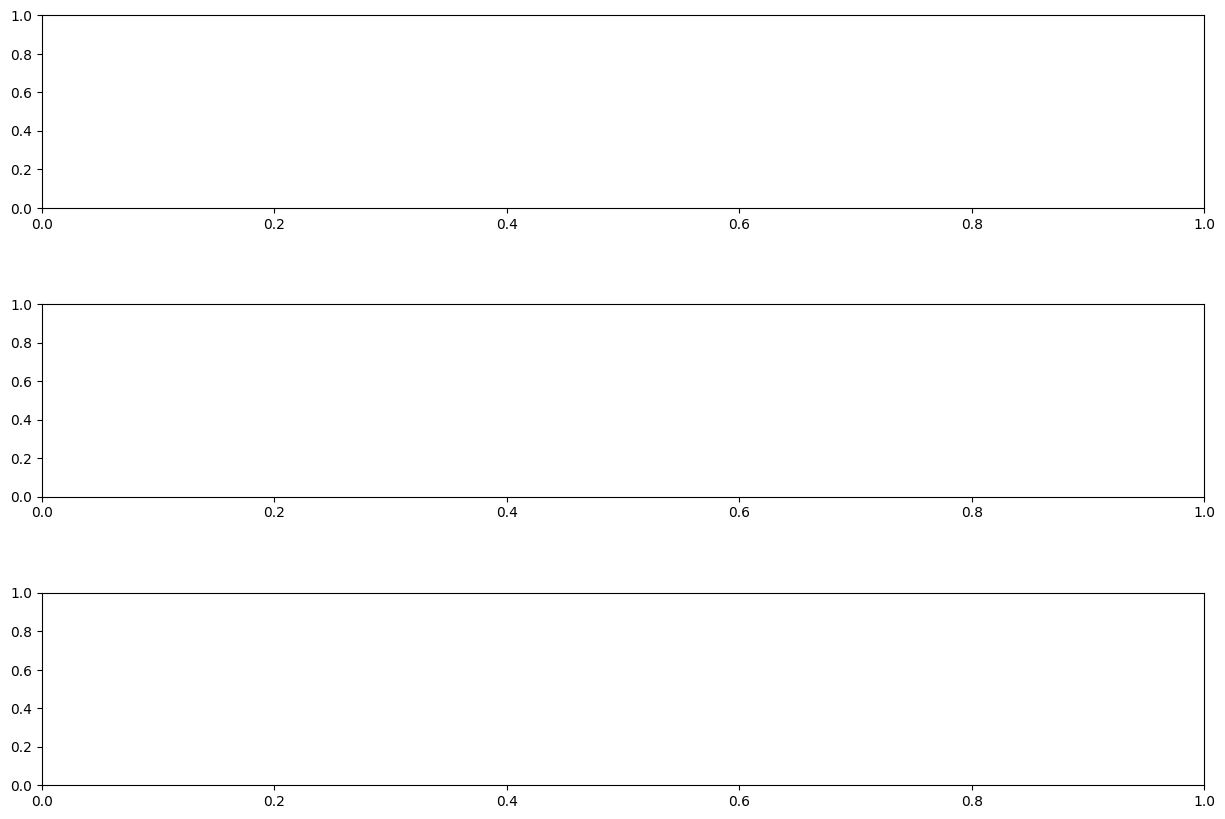

In [7]:
fig, axe = plt.subplots(3, figsize=(15, 10))
plt.subplots_adjust(hspace=0.5, wspace=0.3)
axe[0].set_xlim(0, am_sum)
axe[0].set_ylim(n_min_reward, n_max_reward)
n_days = np.arange(len(n_all_weights))
n_line_collection0 = LineCollection(n_rewards, array=n_days, cmap="rainbow")
axe[0].add_collection(n_line_collection0)
axe[0].vlines(
    start_control_idxs,
    n_min_reward,
    n_max_reward,
    color="green",
    linestyle="dashed",
    label="Start Human Control",
)
axe[0].vlines(
    end_control_idxs,
    n_min_reward,
    n_max_reward,
    color="magenta",
    linestyle="dashed",
    label="End Human Control",
)
# axe[0,1].errorbar(np.arange(am_sum),np.mean(all_rewards,axis=0),yerr=np.std(all_rewards,axis=0),color="black",label="Mean")
# axe[0,1].plot(np.arange(am_sum),np.median(all_rewards,axis=0),color="green",label="Median")
axe[0].set_title("Reward Signal (t0012)")
axe[0].set_xlabel("Timestep")
axe[0].set_ylabel("Reward")
axe[0].legend(loc="upper left")
fig.colorbar(n_line_collection0, label="Day")

axe[1].set_xlim(0, am_sum)
axe[1].set_ylim(0, n_max_weight)
n_line_collection1 = LineCollection(n_all_weights, array=n_days, cmap="rainbow")
axe[1].add_collection(n_line_collection1)
axe[1].vlines(
    start_control_idxs,
    0,
    n_max_weight,
    color="green",
    linestyle="dashed",
    label="Start Human Control",
)
axe[1].vlines(
    end_control_idxs,
    0,
    n_max_weight,
    color="magenta",
    linestyle="dashed",
    label="End Human Control",
)
axe[1].set_title("Importance Weighting (t0012)")
axe[1].set_xlabel("Timestep")
axe[1].set_ylabel("Weight")
axe[1].legend(loc="upper left")
fig.colorbar(n_line_collection1, label="Day")

sns.heatmap(norm_rewards, cmap="cool", ax=axe[2, 1], cbar_kws={"label": "Reward"})
axe[2].invert_yaxis()
axe[2].set_xlabel("Timestep")
axe[2].set_ylabel("Day")
axe[2].set_title("Relative Reward Signal Heatmap (t0012)")
plt.show()

In [ ]:
# fig, ax = plt.subplots()
# ax.plot(pr)
# ax.set_title("Preference Prediction (for segment 2) Versus Day")
# ax.set_xlabel("Day")
# ax.set_ylabel("Probability of Preferred Label")
# plt.show()